In [92]:
import pandas as pd
import numpy as np 
from pyarrow.feather import read_feather
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import time 
import plotnine as pn
os.chdir('/data/swamyvs/Distill')

Start with numeric training data, and see how we do for that 

In [3]:
class SklDataObj:
    def __init__(self, X_data, Y_target,name=None):
        self.targets = Y_target
        X_train, X_tmp, Y_train, Y_tmp =train_test_split(X_data,Y_target,test_size=.3, 
                                                                                  random_state=42,stratify=Y_target)
        X_test, X_val, Y_test, Y_val = train_test_split(X_tmp, Y_tmp, test_size =.666, stratify = Y_tmp, random_state = 32 )
        self.X_train=X_train
        self.Y_train=Y_train
        self.X_test=X_test
        self.Y_test=Y_test
        self.X_val=X_val
        self.Y_val=Y_val
        self.name=name
        self.model = None
    def train(self, model, model_name=None):
        self.model = model
        start = time.time()
        self.model.fit(self.X_train, self.Y_train)
        end = time.time()
        diff = end - start
        print(f'Training Time: {int(diff/60)} min {diff%60} seconds\n')
        self.model_name = model_name
    def test(self):
        self.Y_test_predicted =  self.model.predict(self.X_test)
        cr = classification_report(self.Y_test, self.Y_test_predicted)
        print(cr)


In [96]:
training_data = read_feather('feather_data/clean/ml_set_general_train.ftr')
test_data = read_feather('feather_data/clean/ml_set_general_test.ftr')
allX_data = read_feather('feather_data/clean/allX.ftr')
colombia = read_feather('feather_data/clean/colombia.ftr')

In [102]:
colombia['DataSet'] = 'colombia'
colombia['all_datasets'] = 'colombia'

In [101]:
colombia['DataSet']

0        colombia
1        colombia
2        colombia
3        colombia
4        colombia
           ...   
14458    colombia
14459    colombia
14460    colombia
14461    colombia
14462    colombia
Name: DataSet, Length: 14463, dtype: object

In [5]:
training_data['DataSet'] = 'train'
test_data['DataSet'] = 'test'

In [6]:
numeric_preds = pd.read_csv('ref/numeric_predictors.txt', header= None).iloc[:,0].to_numpy()

In [7]:
training_data.Status.value_counts()

NotPathogenic    856371
Pathogenic         3004
Name: Status, dtype: int64

In [8]:
test_data.Status.value_counts()

NotPathogenic    367015
Pathogenic         1290
Name: Status, dtype: int64

In [9]:
allX_data.Status.value_counts()

NotPathogenic    180274
Pathogenic        92609
Name: Status, dtype: int64

In [10]:
allX_data.groupby('all_datasets').Status.value_counts().sort_index(level=['all_datasets', 'Status'])


all_datasets         Status       
ClinVar HC           NotPathogenic     3926
                     Pathogenic         314
ClinVar LC Path      Pathogenic       39872
DDL NISC RD Cohort   NotPathogenic     1149
                     Pathogenic          71
Grimm ExoVar         NotPathogenic     3395
                     Pathogenic         268
Grimm ExoVar/HumVar  NotPathogenic      279
                     Pathogenic        4071
Grimm HumVar         NotPathogenic    18633
                     Pathogenic       13653
Grimm PredictSNP     NotPathogenic     6064
                     Pathogenic        9999
Grimm SwissVar       NotPathogenic     7848
                     Pathogenic        4506
Grimm VariBench      NotPathogenic     5912
                     Pathogenic        4027
Homsy                NotPathogenic      686
                     Pathogenic         975
Samocha              NotPathogenic     1269
                     Pathogenic        5113
UK10K                NotPathogenic    955

Merge clinvar and uk10k datasets, and split welderly since its completely non pathogenic
theres a ton of pathgenic samples in clinvar, and a ton of non pathogenic samples in the uk10k set. I'm going to take out half of each, and add them back (the first time I ran this, the models did horrible on uk10k


In [103]:
allX_data_collapsed = allX_data.copy()

allX_data_collapsed.loc[:,'all_datasets'] = allX_data_collapsed['all_datasets'].replace(['UK10K;UK10K','ClinVar HC', 'ClinVar LC Path' ],['UK10K', 'clinvar', 'clinvar'])
#allX_data['all_datasets'] = allX_data['all_datasets'].replace(to_replace='^Grimm(.+)', value = 'SuperGrimm', regex=True)
allX_data_collapsed.loc[:,'DataSet']= allX_data_collapsed['all_datasets']


remove_wellderly = allX_data_collapsed['DataSet'] == 'Wellderly'
remove_uk10k = (allX_data_collapsed['DataSet'] == 'UK10K') & (allX_data_collapsed['Status'] == 'NotPathogenic')
remove_clinvar = (allX_data_collapsed['DataSet'] == 'clinvar') & (allX_data_collapsed['Status'] == 'Pathogenic')

wellderly_data = allX_data_collapsed[remove_wellderly.to_numpy()]
uk10k_data_np= allX_data_collapsed[remove_uk10k.to_numpy()]
clinvar_data_p  =  allX_data_collapsed[remove_clinvar.to_numpy()]
allX_data_collapsed = allX_data_collapsed[(~remove_clinvar.to_numpy())&(~remove_uk10k.to_numpy())&(~remove_wellderly.to_numpy())]
uk10k_data_np_hold, uk10k_data_np_allx = train_test_split(uk10k_data_np, test_size = .5, random_state = 12)
clinvar_p_hold, clinvar_p_allx = train_test_split(clinvar_data_p, test_size = .5, random_state=23)
allX_data_collapsed = pd.concat([allX_data_collapsed,
                                 uk10k_data_np_allx,
                                 clinvar_p_allx, 
                                 colombia.filter(allX_data_collapsed.columns )])
allX_data_collapsed.groupby('all_datasets').Status.value_counts().sort_index(level=['all_datasets', 'Status'])

all_datasets         Status       
DDL NISC RD Cohort   NotPathogenic     1149
                     Pathogenic          71
Grimm ExoVar         NotPathogenic     3395
                     Pathogenic         268
Grimm ExoVar/HumVar  NotPathogenic      279
                     Pathogenic        4071
Grimm HumVar         NotPathogenic    18633
                     Pathogenic       13653
Grimm PredictSNP     NotPathogenic     6064
                     Pathogenic        9999
Grimm SwissVar       NotPathogenic     7848
                     Pathogenic        4506
Grimm VariBench      NotPathogenic     5912
                     Pathogenic        4027
Homsy                NotPathogenic      686
                     Pathogenic         975
Samocha              NotPathogenic     1269
                     Pathogenic        5113
UK10K                NotPathogenic    61785
                     Pathogenic         237
UniFun               NotPathogenic     2016
                     Pathogenic        95

In [84]:
model_data_rebuilt = pd.concat([ training_data,
                                test_data.filter(training_data.columns),
                                uk10k_data_np_hold.filter(training_data.columns),
                                clinvar_p_hold.filter(training_data.columns)]    
                              )
model_data_rebuilt['target'] = np.where(model_data_rebuilt['Status'] == 'Pathogenic', 1, 0)

In [85]:
model_data_rebuilt.Status.value_counts()

NotPathogenic    1285170
Pathogenic         24387
Name: Status, dtype: int64

Significantly more pathogenic samples than nonpathogenic in this set

Stategy: Train Distill-V1 on old training data, and Distill-V2 on reshaped set: evaluate on allX data + wellderly

In [86]:
V1_X_train = training_data.filter(numeric_preds)
V1_Y_train = np.where(training_data['Status'] == 'Pathogenic', 1,0)
V1_X_test = test_data.filter(numeric_preds)
V1_Y_test = np.where(test_data['Status'] == 'Pathogenic', 1, 0)
distill_v1 = XGBClassifier(tree_method = 'gpu_hist', gpu_id = 0)
distill_v1.fit(V1_X_train, V1_Y_train)
preds= distill_v1.predict(V1_X_test)
print(classification_report(V1_Y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    367015
           1       0.77      0.17      0.28      1290

    accuracy                           1.00    368305
   macro avg       0.88      0.59      0.64    368305
weighted avg       1.00      1.00      1.00    368305



In [87]:
X_data = model_data_rebuilt.filter(numeric_preds)
Y_data = model_data_rebuilt['target']
data_obj = SklDataObj(X_data, Y_data)
xgbc_gpu = XGBClassifier(tree_method = 'gpu_hist', gpu_id = 0)
data_obj.train(xgbc_gpu)
data_obj.test()
distill_v2 = data_obj.model

Training Time: 0 min 7.694833040237427 seconds

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    128773
           1       0.93      0.78      0.85      2444

    accuracy                           0.99    131217
   macro avg       0.96      0.89      0.92    131217
weighted avg       0.99      0.99      0.99    131217



In [111]:
from sklearn.metrics import precision_recall_curve, auc
other_model_preds = ['revel','cadd_phred', 'fitcons', 'metalr_rankscore', 'fathmm_converted_rankscore', 'm_cap_rankscore']
def pr_df(Y_true, Y_pred, label, dataset):
    prec, rec, thresh =  precision_recall_curve(Y_true, Y_pred)
    auprc=round(auc(rec, prec), 3)
    label_auc = f'{label} (AUC: {str(auprc)})'
    return pd.DataFrame({'model':label, 'precision' : prec, 'recall': rec, 'dataset':dataset, 'labelauc':label_auc, 'auc':auprc})

def validate_model_on_allx(model, X_data, numeric_preds,model_name=None, other_model_preds=None):
    Y_true = np.where(X_data['Status'] == 'Pathogenic', 1, 0)
    #X_preds_only = X_data.filter(other_model_preds).replace(-1, 0)
    dataset =X_data.DataSet.unique()[0]
    path_prob = model.predict_proba(X_data.filter(numeric_preds))[:,1]
    #prob_df = pd.DataFram({'True Class': Y_true, 'prob': path_prob})
    distill_prediction_df = pr_df(Y_true,path_prob  , model_name, dataset)
#     other_predictions = [ pr_df(Y_true,X_preds_only[predictor].to_numpy(), predictor, dataset)  for predictor in other_model_preds ]
    #other_predictions +=[distill_prediction_df]
    return distill_prediction_df
    
def validate_other_models_on_allx(X_data, predictor,):
    X_data = X_data[~X_data[predictor].isnull()]
    Y_true = np.where(X_data['Status'] == 'Pathogenic', 1, 0)
    #X_preds_only = X_data.filter(other_model_preds).replace(-1, 0)
    dataset =X_data.DataSet.unique()[0]
    path_prob = X_data[predictor]
    #prob_df = pd.DataFram({'True Class': Y_true, 'prob': path_prob})
    distill_prediction_df = pr_df(Y_true,path_prob , predictor, dataset)
#     other_predictions = [ pr_df(Y_true,X_preds_only[predictor].to_numpy(), predictor, dataset)  for predictor in other_model_preds ]
    #other_predictions +=[distill_prediction_df]
    return distill_prediction_df
    

In [104]:
distill_v1_predictions= (allX_data_collapsed
                         .groupby('DataSet')
                         .apply(lambda x: validate_model_on_allx(distill_v1, x, numeric_preds, 'distill-v1' )) ).reset_index(drop = True )
distill_v2_predicitions = (allX_data_collapsed
                         .groupby('DataSet')
                         .apply(lambda x: validate_model_on_allx(distill_v2, x, numeric_preds, 'distill-v2' )) ).reset_index(drop = True )
all_distill_predictions = pd.concat([distill_v1_predictions, distill_v2_predicitions])

In [112]:
other_pred_pr = [ (allX_data_collapsed
                   .groupby('DataSet')
                   .apply(lambda x: validate_other_models_on_allx( x, p))
                  )   for p in other_model_preds ]

In [117]:
all_pred_pr_df = pd.concat(other_pred_pr+ [distill_v1_predictions,distill_v2_predicitions])

In [105]:
labdf = all_distill_predictions[['model', 'dataset', 'auc']].drop_duplicates()
labdf

,model,dataset,auc
0,distill-v1,DDL NISC RD Cohort,0.481
710,distill-v1,Grimm ExoVar,0.832
3611,distill-v1,Grimm ExoVar/HumVar,0.997
7926,distill-v1,Grimm HumVar,0.960
35293,distill-v1,Grimm PredictSNP,0.957
50299,distill-v1,Grimm SwissVar,0.711
61698,distill-v1,Grimm VariBench,0.828
70944,distill-v1,Homsy,0.631
72569,distill-v1,Samocha,0.868
78500,distill-v1,UK10K,0.257


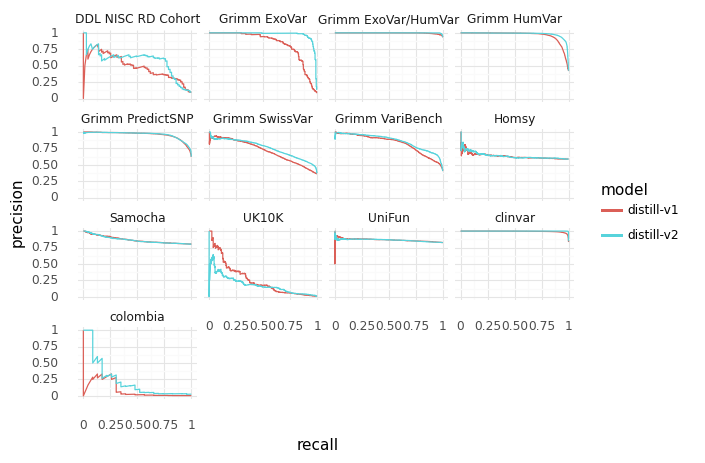

<ggplot: (2933275720805)>

In [106]:
(
 pn.ggplot(all_distill_predictions)+
    pn.geom_path( pn.aes(x='recall', y='precision', color = 'model') )+
    pn.facet_wrap('~dataset')+
    pn.theme_minimal()
)

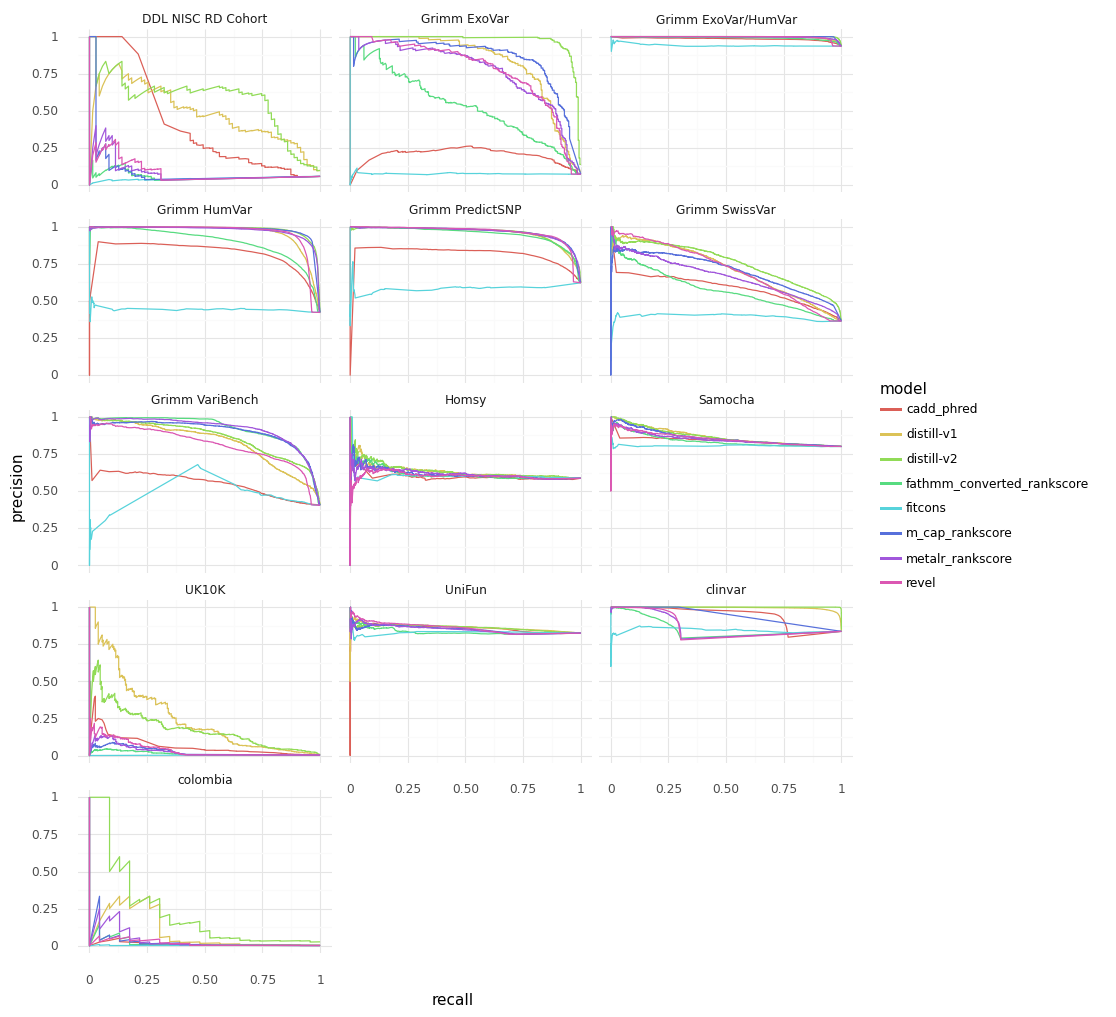

<ggplot: (2933175670325)>

In [124]:
(
 pn.ggplot(all_pred_pr_df)+
    pn.geom_path( pn.aes(x='recall', y='precision', color = 'model') )+
    pn.facet_wrap('~dataset', ncol =3)+
    pn.theme_minimal()+
    pn.theme(figure_size = (10,12))
)